In [133]:
# Harris and Walz Notebook
# Import libraries
import pandas as pd
import requests
import json


In [134]:
with open('params.json') as param_json:
    params = json.load(param_json)

CLIENT_ID = params['CLIENT_ID']
SECRET_TOKEN = params['SECRET_TOKEN']
USERNAME = params['USERNAME']
PASSWORD = params['PASSWORD']
KEYWORDS = params['KEYWORDS']
keywords = [word.lower() for word in KEYWORDS]

In [135]:

    # note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_TOKEN)
    
    # here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': USERNAME,
         'password': PASSWORD}
    
    # setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}
    
    # send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                     auth=auth, data=data, headers=headers)
    
    # convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']
    
    # add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}
    
    # while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)


<Response [200]>

In [136]:
def get_post(subreddit, cats, concated_df):
    '''
    Gets post from passed subreddits. 
    params: 
        subreddit - the subreddit to pull post from 
        cats - 'hot' or 'rising' which are filters on subreddits to find trending post 
        concated_df - dataframe from yesterday which contains post from previous day. 
    '''

    res = requests.get(f"https://oauth.reddit.com/r/{subreddit}/{cats}",
                       headers=headers)
    data = res.json()
    #print(data)
    posts = data['data']['children']
    posts_data = []

    for post in posts:
        post_info = post['data']
        posts_data.append({
            'title': post_info['title'],
            'upvote_ratio': post_info['upvote_ratio'],
            'subreddit_name_prefixed': post_info['subreddit_name_prefixed'],
            'date': post_info['created_utc']

        })

        # Create a DataFrame
    df = pd.DataFrame(posts_data)

    df['date'] = pd.to_datetime(df['date'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    df['title'] = df['title'].apply(lambda x: x.lower())
    df = df[df['title'].apply(lambda word: any(keyword in word for keyword in keywords))]

    newDF = pd.concat([df, concated_df], ignore_index=True)

    return newDF


In [137]:
def subreddits():
    '''
    Runs the "get_post" function on all of our subreddits. Outputs a new csv called 'titles'. 
    Titles contains: 
        - post title 
        - subreddit name
        - ratio of upvotes to downvotes
        - date published 
    :return: 
    '''
    
    with open('output/titles.csv') as maindf:
        main_df = pd.read_csv(maindf)

    df = get_post("politics", "hot", main_df)
    df = get_post("democrats", "rising", df)
    df = get_post("politicaldiscussion", "rising", df)
    df = get_post("politicaldiscussion", "hot", df)
    df = get_post("moderatepolitics", "rising", df)
    df = get_post("moderatepolitics", "hot", df)
    df = get_post("democrats", "hot", df)
    df = get_post("politics", "rising", df)
    df = get_post("politics", "hot", df)
    df = get_post("republicans", "rising", df)
    df = get_post("republicans", "hot", df)
    df = df[['title', 'upvote_ratio', 'subreddit_name_prefixed', 'date']]
    df = df.drop_duplicates()
    df.to_csv('output/titles.csv')


In [138]:
subreddits()

In [140]:
df = pd.read_csv('output/titles.csv')
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.to_csv('output/titles.csv')

864
820


### Word Clouds! 

In [228]:
import nltk
import matplotlib.pyplot as plt 
from datetime import date
import wordcloud
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [229]:
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
sw = set(stopwords.words('english'))
sw.update(['harris', 'kamala', 'kamala harris', 'walz', 'tim walz', 'tim', 'say', 'lol'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/KenedyDucheine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [244]:
def wc(dataframe):
    df = dataframe
    for i in df['subreddit_name_prefixed']: 
        
        newdf = df[df['subreddit_name_prefixed']== i]
        newdf = newdf.drop_duplicates(subset = ['title'])
        newdf['title'] = newdf['title'].str.translate(str.maketrans('', '', string.punctuation))
        textlist = [word_tokenize(w) for w in newdf['title']]
        tkwords = [word for n in textlist for word in n if word.lower() not in sw]
        strings = ' '.join(tkwords)
        
        wc = WordCloud(background_color= '#FFFFFF', colormap= 'Reds').generate(strings)
        plt.axis('off')
        plt.figtext(0.3,0.8,(f'{i} WordCloud: {date.today()}'),fontweight='bold')

        plt.imshow(wc)
        plt.savefig(f'output/wordclouds/{i}_wordcloud_{date.today()}.png')
        plt.imshow(wc)



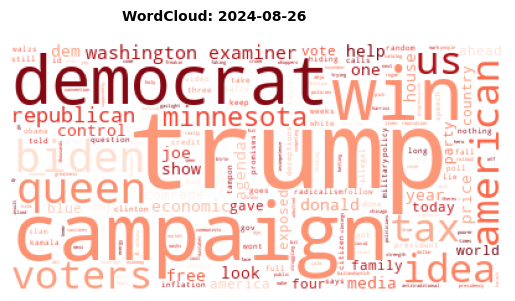

In [243]:
repub = df[df['subreddit_name_prefixed']=='r/republicans']
repub = repub.drop_duplicates(subset = ['title'])
repub['title'] = repub['title'].str.translate(str.maketrans('', '', string.punctuation))
r_textlist = [word_tokenize(w) for w in repub['title']]
r_tkwords = [word for n in r_textlist for word in n if word.lower() not in sw]
rstring = ' '.join(r_tkwords)


wc = WordCloud(background_color= '#FFFFFF', colormap= 'Reds').generate(rstring)
plt.axis('off')
plt.figtext(0.3,0.8,(f'WordCloud: {date.today()}'),fontweight='bold')

plt.imshow(wc)
plt.savefig(f'output/wordclouds/wordcloud_{date.today()}.png')
plt.imshow(wc)





In [ ]:
demo = df[df['subreddit_name_prefixed']=='r/democrats']
d_textlist = [w for w in demo['title']]
all_list = [w for w in df['title']]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/KenedyDucheine/DataspellProjects/Harris_and_Walz/output/wordclouds/r/republicans_wordcloud_2024-08-26.png'

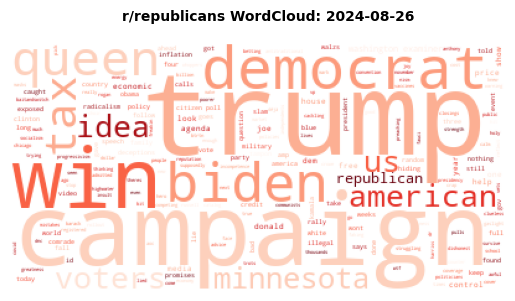

In [245]:
wc(df)